In [1]:
from pyspark.sql.functions import col

# Yelp Businesses
business_filename = "GCP bucket name"
business_sdf = spark.read.json(business_filename)
business_sdf = business_sdf.withColumnRenamed('stars', 'business_stars') \
                           .withColumnRenamed('name', 'business_name') \
                           .withColumnRenamed('review_count', 'business_review_count') \
                           .withColumnRenamed('categories', 'business_categories')
business_sdf = business_sdf.drop('city', 'hours', 'is_open', 'latitude', 'longitude', 'postal_code', 'state', 'address', 'attributes')
# Yelp Users
users_filename = "GCP bucket name"
users_sdf = spark.read.json(users_filename)
# Rename all of the columns except for user_id
users_sdf = users_sdf.select([col("user_id").alias("user_id")] + [col(c).alias("user_"+c) for c in users_sdf.columns if c != "user_id"])
# Yelp Reviews
reviews_filename = "GCP bucket name"
reviews_sdf = spark.read.json(reviews_filename)
reviews_sdf = reviews_sdf.withColumnRenamed('stars', 'review_stars')
reviews_sdf = reviews_sdf.drop('review_id', 'date')
# Join the three datasets together
yelp_sdf = reviews_sdf.join(business_sdf, "business_id")
yelp_sdf = yelp_sdf.join(users_sdf, "user_id")

yelp_sdf.printSchema()

24/12/06 09:08:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- business_categories: string (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_review_count: long (nullable = true)
 |-- business_stars: double (nullable = true)
 |-- user_average_stars: double (nullable = true)
 |-- user_compliment_cool: long (nullable = true)
 |-- user_compliment_cute: long (nullable = true)
 |-- user_compliment_funny: long (nullable = true)
 |-- user_compliment_hot: long (nullable = true)
 |-- user_compliment_list: long (nullable = true)
 |-- user_compliment_more: long (nullable = true)
 |-- user_compliment_note: long (nullable = true)
 |-- user_compliment_photos: long (nullable = true)
 |-- user_compliment_plain: long (nullable = true)
 |-- user_compliment_profile: lo

In [2]:
gcs_path = "GCP bucket name"
df = spark.read.json(gcs_path)
df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [2]:
num_records = df.count()
print(f"Number of records: {num_records}")
print(f"List of variables: {df.columns}")

Number of records: 10169368
List of variables: ['address', 'attributes', 'average_stars', 'business_id', 'categories', 'city', 'compliment_cool', 'compliment_count', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'date', 'elite', 'fans', 'friends', 'funny', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'review_id', 'stars', 'state', 'text', 'useful', 'user_id', 'yelping_since']


In [3]:
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+--------+----------+-------------+-----------+----------+--------+---------------+----------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-------+-------+-------+-------+-------+-------+--------+--------+--------+---------+-------+-----------+------------+---------+-------+--------+-------+-------+-------+-------------+
| address|attributes|average_stars|business_id|categories|    city|compliment_cool|compliment_count|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|   cool|   date|  elite|   fans|friends|  funny|   hours| is_open|latitude|longitude|   name|postal_code|review_count|review_id|  stars|   state|   text| useful|user_id|yelping_since|
+--------+----------+-------------+-----------+----------+--------+---------------+-------------

In [4]:
from pyspark.sql.functions import min, max, avg, stddev

numeric_columns = [c for c, dtype in df.dtypes if dtype in ['int', 'double']]
summary_stats = df.select([min(c).alias(f'{c}_min') for c in numeric_columns] +
                          [max(c).alias(f'{c}_max') for c in numeric_columns] +
                          [avg(c).alias(f'{c}_avg') for c in numeric_columns] +
                          [stddev(c).alias(f'{c}_stddev') for c in numeric_columns])
summary_stats.show()


+-----------------+------------+-------------+---------+-----------------+------------+--------------+---------+------------------+----------------+-----------------+-----------------+--------------------+-----------------+------------------+------------------+
|average_stars_min|latitude_min|longitude_min|stars_min|average_stars_max|latitude_max| longitude_max|stars_max| average_stars_avg|    latitude_avg|    longitude_avg|        stars_avg|average_stars_stddev|  latitude_stddev|  longitude_stddev|      stars_stddev|
+-----------------+------------+-------------+---------+-----------------+------------+--------------+---------+------------------+----------------+-----------------+-----------------+--------------------+-----------------+------------------+------------------+
|              1.0|   27.555127|  -120.095137|      1.0|              5.0|  53.6791969|-73.2004570502|      5.0|3.6304941503508696|36.6711500641456|-89.3573394897131|3.745386328873687|  1.1833369995975145|5.8727589

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

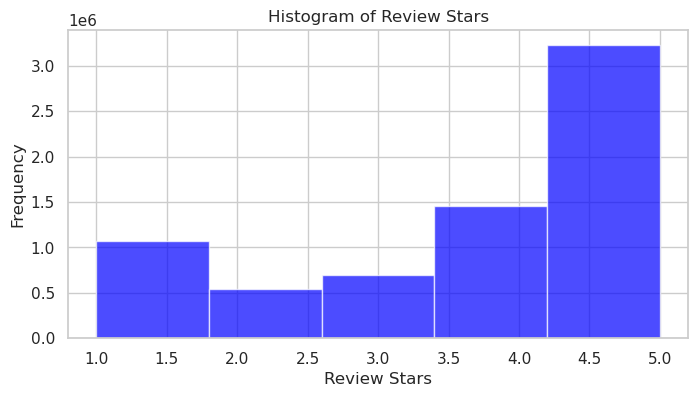

In [4]:
review_stars_pd = yelp_sdf.select("review_stars").toPandas()

plt.figure(figsize=(8, 4))
plt.hist(review_stars_pd['review_stars'], bins=5, color='blue', alpha=0.7)
plt.title('Histogram of Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Frequency')
plt.show()

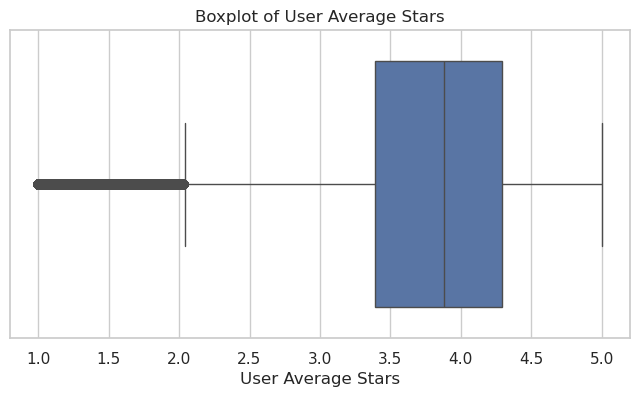

In [5]:
user_avg_stars_pd = yelp_sdf.select("user_average_stars").toPandas()

plt.figure(figsize=(8, 4))
sns.boxplot(x=user_avg_stars_pd['user_average_stars'])
plt.title('Boxplot of User Average Stars')
plt.xlabel('User Average Stars')
plt.show()

/tmp/ipykernel_3034/236693627.py:10: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='category', data=category_counts_pd, palette='viridis')


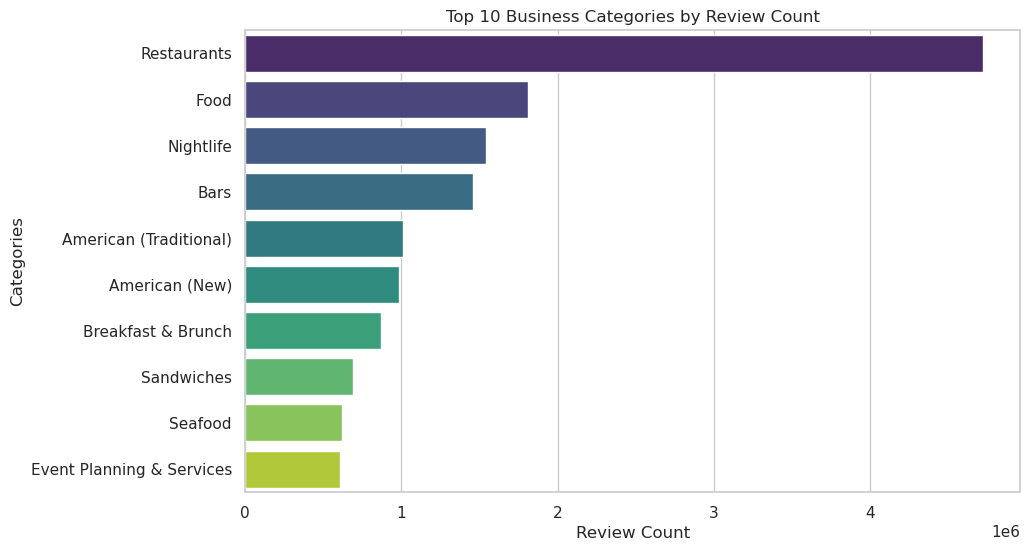

In [6]:
from pyspark.sql.functions import explode, split

# Expanding the business categories into separate rows
categories_df = yelp_sdf.withColumn("category", explode(split(col("business_categories"), ", ")))
category_counts = categories_df.groupBy("category").count().orderBy("count", ascending=False).limit(10)

category_counts_pd = category_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='category', data=category_counts_pd, palette='viridis')
plt.title('Top 10 Business Categories by Review Count')
plt.xlabel('Review Count')
plt.ylabel('Categories')
plt.show()

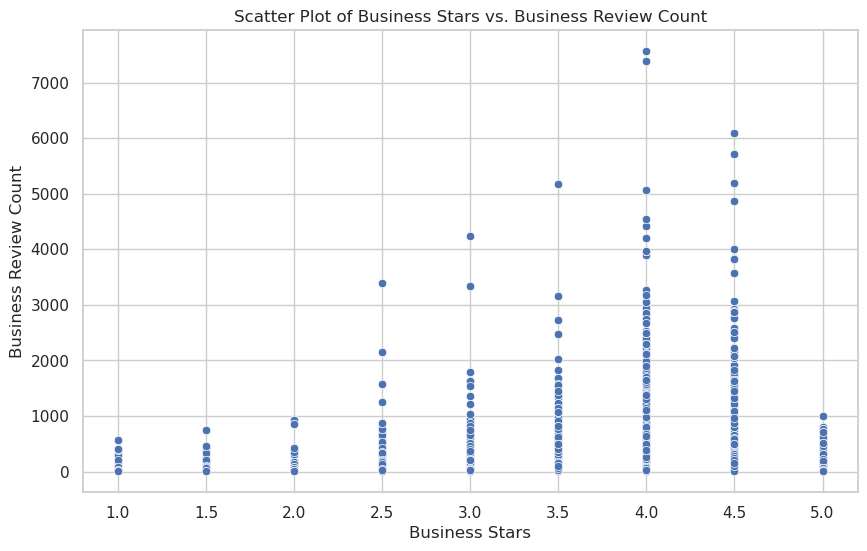

In [8]:
business_data_pd = yelp_sdf.select("business_stars", "business_review_count").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot( x='business_stars', y='business_review_count', data=business_data_pd)
plt.title('Scatter Plot of Business Stars vs. Business Review Count')
plt.xlabel('Business Stars')
plt.ylabel('Business Review Count')
plt.show()